<a href="https://colab.research.google.com/github/hyunjaec/MScA_Machine_Learning_Project/blob/main/medical_deepfakes_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
try:
  import pydicom
except:
  ! pip install pydicom
  import pydicom
import scipy.ndimage

     |████████████████████████████████| 2.0 MB 4.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = os.listdir(dicom_folder)
    first_slice_data = pydicom.read_file(os.path.join(path2scan_dir,dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient) #zyx format
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = np.float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]]) #zyx format

    scan = np.zeros((len(dcms),first_slice.shape[0],first_slice.shape[1]))
    raw_slices=[]
    indexes = []
    for dcm in dcms:
        slice_data = pydicom.read_file(os.path.join(dicom_folder,dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    indexes = np.array(indexes,dtype=float)

    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    origin = np.array(raw_slices[0][0x00200032].value) #origin is assumed to be the image location of the first slice
    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.array([origin[2],origin[1],origin[0]]) #change from x,y,z to z,y,x

    for i, slice in enumerate(raw_slices):
        scan[i, :, :] = slice.pixel_array
    return scan, spacing, orientation, origin, raw_slices

In [ ]:
! ls '/content/drive/My Drive/data/Tampered Scans/Experiment 2 - Open/2575'

0.dcm	 132.dcm  165.dcm  198.dcm  22.dcm   262.dcm  295.dcm  35.dcm  68.dcm
100.dcm  133.dcm  166.dcm  199.dcm  230.dcm  263.dcm  296.dcm  36.dcm  69.dcm
101.dcm  134.dcm  167.dcm  19.dcm   231.dcm  264.dcm  297.dcm  37.dcm  6.dcm
102.dcm  135.dcm  168.dcm  1.dcm    232.dcm  265.dcm  298.dcm  38.dcm  70.dcm
103.dcm  136.dcm  169.dcm  200.dcm  233.dcm  266.dcm  299.dcm  39.dcm  71.dcm
104.dcm  137.dcm  16.dcm   201.dcm  234.dcm  267.dcm  29.dcm   3.dcm   72.dcm
105.dcm  138.dcm  170.dcm  202.dcm  235.dcm  268.dcm  2.dcm    40.dcm  73.dcm
106.dcm  139.dcm  171.dcm  203.dcm  236.dcm  269.dcm  300.dcm  41.dcm  74.dcm
107.dcm  13.dcm   172.dcm  204.dcm  237.dcm  26.dcm   301.dcm  42.dcm  75.dcm
108.dcm  140.dcm  173.dcm  205.dcm  238.dcm  270.dcm  302.dcm  43.dcm  76.dcm
109.dcm  141.dcm  174.dcm  206.dcm  239.dcm  271.dcm  303.dcm  44.dcm  77.dcm
10.dcm	 142.dcm  175.dcm  207.dcm  23.dcm   272.dcm  304.dcm  45.dcm  78.dcm
110.dcm  143.dcm  176.dcm  208.dcm  240.dcm  273.dcm  305.dcm  46.dc

In [ ]:
! ls '/content/drive/My Drive/ML_Project/Project/data/Tampered Scans/Experiment 2 - Open/1251'

ls: cannot access '/content/drive/My Drive/ML_Project/Project/data/Tampered Scans/Experiment 2 - Open/1251': No such file or directory


In [ ]:
scan_uuid = 2575
scan, spacing, orientation, origin, raw_slices = load_dicom('/content/drive/My Drive/data/Tampered Scans/Experiment 2 - Open/'+str(scan_uuid))
#scan, spacing, orientation, origin, raw_slices = load_dicom('/content/drive/My Drive/ML_Project/Project/data/Tampered Scans/Experiment 1 - Blind/'+str(scan_uuid))

print('The CT scan has the dimensions of',scan.shape,'  (z,y,x)')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


The CT scan has the dimensions of (324, 512, 512)   (z,y,x)


In [ ]:

scan_uuid = 1280
scan, spacing, orientation, origin, raw_slices = load_dicom('/content/drive/My Drive/data/Tampered Scans/Experiment 1 - Blind/'+str(scan_uuid))

print('The CT scan has the dimensions of',scan.shape,'  (z,y,x)')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


The CT scan has the dimensions of (133, 512, 512)   (z,y,x)


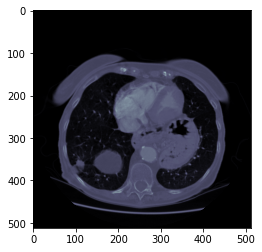

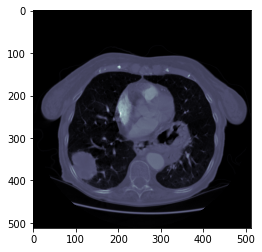

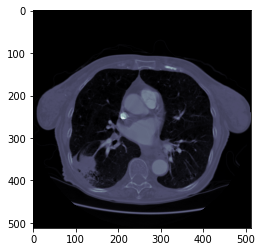

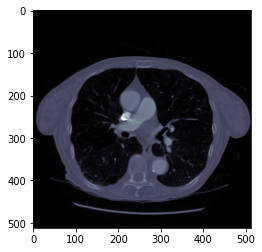

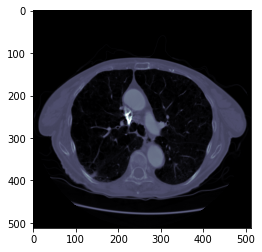

In [ ]:
from matplotlib import pyplot as plt

for slice_indx in range(50,100,10):
    plt.imshow(scan[slice_indx,:,:],cmap='bone',vmin=-1000,vmax=2000)
    plt.show()

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/Tampered Scans/labels_exp2.csv')  
locations = df.loc[df['uuid']==scan_uuid]
locations

,type,uuid,slice,x,y


In [ ]:
def cutCube(X, center, shape, padd=0): #center is a 3d coord (zyx)
    center = center.astype(int)
    hlz = np.round(shape[0] / 2)
    hly = np.round(shape[1] / 2)
    hlx = np.round(shape[2] / 2)

    #add padding if out of bounds
    if ((center - np.array([hlz,hly,hlx])) < 0).any() or (
        (center + np.array([hlz,hly,hlx]) + 1) > np.array(X.shape)).any():  # if cropping is out of bounds, add padding
        try:
          np.ones(np.array(X.shape) + shape * 2)
        except:
          return "No"
        Xn = np.ones(np.array(X.shape) + shape * 2) * padd
        Xn[shape[0]:(shape[0] + X.shape[0]), shape[1]:(shape[1] + X.shape[1]), shape[2]:(shape[2] + X.shape[2])] = X
        centern = center + shape
        cube = Xn[int(centern[0] - hlz):int(centern[0] - hlz + shape[0]),
               int(centern[1] - hly):int(centern[1] - hly + shape[1]),
               int(centern[2] - hlx):int(centern[2] - hlx + shape[2])]
        return np.copy(cube)
    else:
        cube = X[int(center[0] - hlz):int(center[0] - hlz + shape[0]), int(center[1] - hly):int(center[1] - hly + shape[1]),
               int(center[2] - hlx):int(center[2] - hlx + shape[2])]
        return np.copy(cube)


In [ ]:
cut_cubes = []
for i in range(len(locations)):
    location = locations.iloc[i]
    coord = np.array([location['slice'],location['y'],location['x']])
    cut_cubes.append(cutCube(scan,coord,(64,64,64)))

#disply the slices of each cut cube:
for cube in cut_cubes:
    plt.figure(num=None, figsize=(10, 10), dpi=200)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(cube[i,:,:],cmap='bone')
    plt.show()

In [ ]:
import os
dir = "/content/drive/My Drive/data/Tampered Scans/Experiment 2 - Open/" 
r=[]
for root, dirs, files in os.walk(dir):
  r.append(root)

In [ ]:
label_df1 = pd.read_csv('/content/drive/My Drive/data/Results/Response EXP2 - Reviewer 1_instances.csv')
label_df2 = pd.read_csv('/content/drive/My Drive/data/Results/Response EXP2 - Reviewer 2_instances.csv')
label_df3 = pd.read_csv('/content/drive/My Drive/data/Results/Response EXP2 - Reviewer 3_instances.csv')

preds = pd.concat([label_df1[['label','prediction','confidence']], label_df2[['label','prediction','confidence']], label_df3[['label','prediction','confidence']]], axis = 1)
preds.columns = ['label1','prediction1','confidence1','label2','prediction2','confidence2','label3','prediction3','confidence3']

def final_label(row):
  if row.label1 == row.label2 == row.label3:
    return row.label1
  else:
    return np.sign((row.label1*row.confidence1 + row.label1*row.confidence2 + row.label1*row.confidence3) / 3)

preds['label'] = preds.apply(lambda row: final_label(row), axis = 1)
label_df = pd.concat([label_df1.drop('label', axis = 1), preds['label']], axis = 1)
label_df.head()

,type,uuid,slice,x,y,detected,detected_diam,prediction,confidence,label
0,FB,1251,150,418,350,False,0.0,TB,5.0,True
1,FB,1251,188,402,294,False,0.0,TB,5.0,True
2,FB,1251,272,163,298,False,0.0,TB,5.0,True
3,FB,2592,163,230,322,False,0.0,TB,5.0,True
4,FB,1876,146,414,181,False,0.0,TB,5.0,True


In [ ]:
df_true = label_df.loc[label_df['label']==True]
df_false = label_df.loc[label_df['label']==False]

In [ ]:
df_true.uuid[0]

1251

In [ ]:
df_true = df_true.reset_index()
df_false = df_false.reset_index()

In [ ]:
def image_cut_processing(df):
  cut_cubes = []
  for i in range(0,len(df)):
    scan, spacing, orientation, origin, raw_slices = load_dicom('/content/drive/My Drive/data/Tampered Scans/Experiment 2 - Open/'+str(df.uuid[i]))
    uuid_row = df.loc[df['uuid'] == df.uuid[i]]
    for j in range(len(uuid_row)):
      location = uuid_row.iloc[j]
      coord = np.array([location['slice'],location['y'],location['x']])
      if (cutCube(scan,coord,(64,64,64))) != "No":
        cut_cubes.append(cutCube(scan,coord,(64,64,64)))
  return cut_cubes
  

In [ ]:
true_cut_images = image_cut_processing(df_true)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [ ]:
false_cut_images = image_cut_processing(df_false)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [ ]:
list1 = [True for i in range(len(true_cut_images))]
list2 = [False for i in range(len(false_cut_images))]
y = list1+list2
y = np.array(y)

In [ ]:
y = pd.get_dummies(y)

In [ ]:
X = true_cut_images + false_cut_images

In [ ]:
len(X), len(y)

(72, 72)

In [ ]:
y['label'] = (y[True] == 1).astype(int)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y['label'], test_size=.2)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
len(y_train)

57

In [ ]:
X_test[8].shape, y_train[8].shape

((64, 64, 64), ())

In [ ]:
X_train.shape

(57, 64, 64, 64)

In [ ]:
nsamples, nx, ny, nz = X_train.shape
X_train_flattened = X_train.reshape((nsamples,nx*ny*nz))
X_test_flattened = X_test.reshape((X_test.shape[0],nx*ny*nz))

In [ ]:
X_train_flattened.shape

(57, 262144)

In [ ]:
pip install git+https://github.com/JihongJu/keras-resnet3d.git


  Cloning https://github.com/JihongJu/keras-resnet3d.git to /tmp/pip-req-build-3303uejy
  Running command git clone -q https://github.com/JihongJu/keras-resnet3d.git /tmp/pip-req-build-3303uejy
  Running command git submodule update --init --recursive -q
  Created wheel for keras-resnet3d: filename=keras_resnet3d-0.0.1-py3-none-any.whl size=4765 sha256=2c34c2fb3bd503ca3597035a167e8edab68488379d9adf6c30a352d71837a0c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-y1fymjzx/wheels/7e/d8/d8/79a8e9fdfacb40c998db593c423f1dd764cd65ceb66246d6f1
Successfully built keras-resnet3d


In [ ]:
from resnet3d import Resnet3DBuilder
model = Resnet3DBuilder.build_resnet_50((64, 64, 64,1), 2)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# model.fit(X_train, y_train, batch_size=32)


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: [2626.978271484375, 0.8666666746139526]


In [ ]:
history = model.fit(X_train, y_train,
          batch_size=5, epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/50
12/12 [==============================] - 114s 9s/step - loss: 4.9774 - accuracy: 0.9825 - val_loss: 1488.6079 - val_accuracy: 0.9333
Epoch 2/50
12/12 [==============================] - 108s 9s/step - loss: 5.2204 - accuracy: 0.8596 - val_loss: 851.5679 - val_accuracy: 0.9333
Epoch 3/50
12/12 [==============================] - 111s 9s/step - loss: 4.8809 - accuracy: 0.8421 - val_loss: 2646.9802 - val_accuracy: 0.9333
Epoch 4/50
12/12 [==============================] - 107s 9s/step - loss: 4.4372 - accuracy: 0.9474 - val_loss: 312.9384 - val_accuracy: 0.9333
Epoch 5/50
12/12 [==============================] - 107s 9s/step - loss: 4.2376 - accuracy: 0.9474 - val_loss: 504.4761 - val_accuracy: 0.0667
Epoch 6/50
12/12 [==============================] - 107s 9s/step - loss: 4.0272 - accuracy: 0.9825 - val_loss: 20.2392 - val_accuracy: 0.9333
Epoch 7/50
12/12 [==============================] - 107s 9s/step - loss: 3.7634 - accuracy: 1.0000 - val_loss: 13.6512 - val_accuracy: 0.9333

In [33]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score)


1/1 [==============================] - 8s 8s/step - loss: 1.0688 - accuracy: 1.0000
Test loss: [1.0687724351882935, 1.0]


Text(0.5, 1.0, 'Loss Curves')

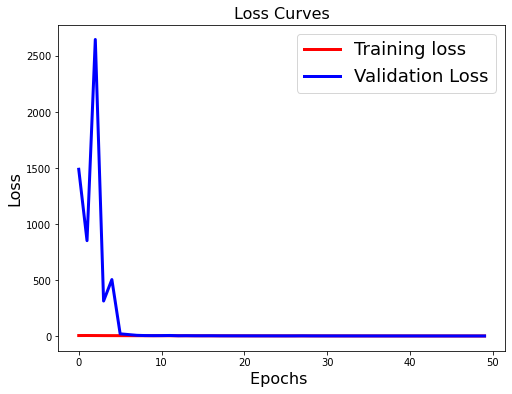

In [34]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [37]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [39]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [42]:
cm

array([[ 1,  0],
       [ 0, 14]])